In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data = pd.read_csv('/home/wahba/Documents/nids3/tests/dataset/cicids2017_data_preprocessing1.csv', encoding='latin1')## Feature importance

In [3]:
print(data['Label'].value_counts())
print(data.info())

Label
BENIGN         2096484
DoS             193748
DDoS            128016
Port Scan        90819
Brute Force       9152
Web Attack        2143
Bot               1953
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2522315 entries, 0 to 2522314
Data columns (total 61 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean    

In [4]:
# Check for completely constant features (all values same)
constant_features = []
for col in data.columns:
    if data[col].nunique() <= 1:
        constant_features.append(col)
        print(f"🛑 {col}: {data[col].nunique()} unique values")

print(f"\nTotal constant features: {len(constant_features)}")


Total constant features: 0


In [5]:
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_columns)

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Subflow Fwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_

## Feature importance

### Kruskal - Wallis test

- Kruskal - Wallis test to identify whether a feature has significantly different distributions across classes
- If a feature is statistically different between classes, it is likely useful for classification

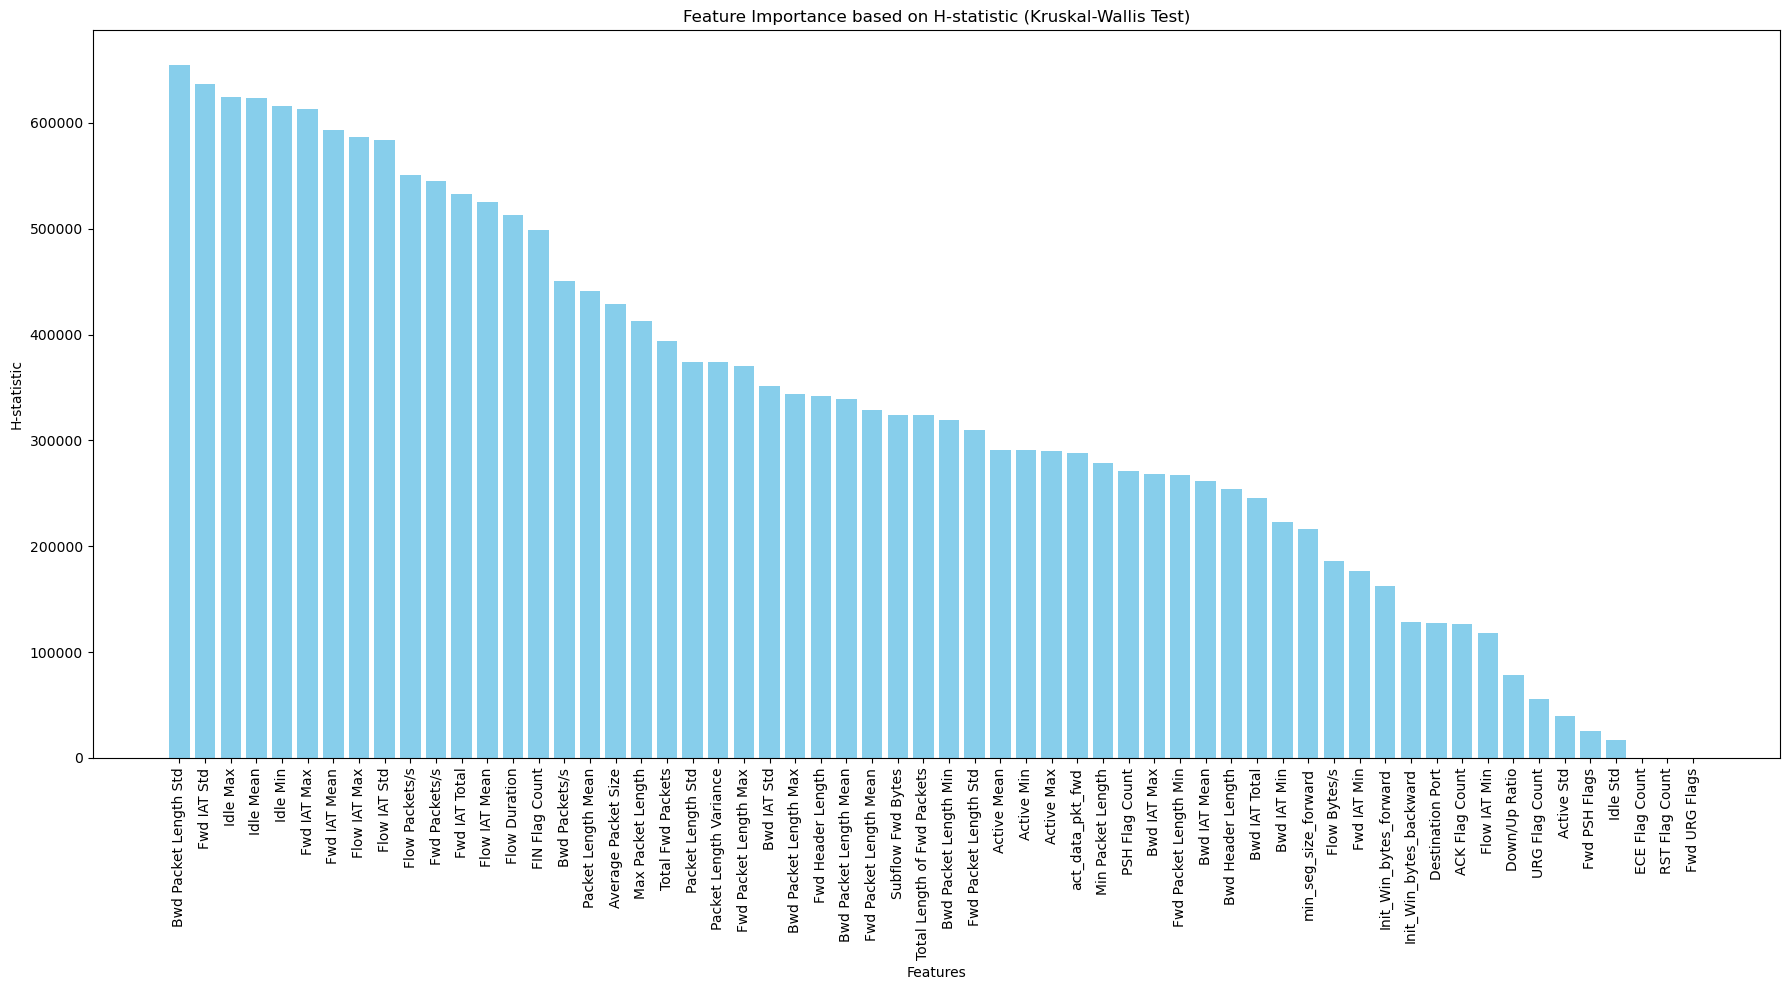

In [6]:
from scipy import stats

h_scores = {}

for feature in numeric_columns:  
    # Group data by y and perform the Kruskal-Wallis test  
    groups = [group[feature].dropna().values for name, group in data.groupby('Label')]  
    h_stat, p_val = stats.kruskal(*groups)  
    h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

# Convert the results to a DataFrame for better visualization
h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')
h_scores_df = h_scores_df.sort_values(by='H-statistic', ascending=False)

# Plotting H-statistics  
plt.figure(figsize=(18, 10))  
plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
plt.xlabel('Features')  
plt.ylabel('H-statistic')  
plt.tight_layout()  
plt.show()  

## Random Forest

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# Hyperparameter settings
hyperparameters = {
    'n_estimators': 150,    # Number of trees
    'max_depth': 30,        # Limit tree depth
    'random_state': 42,     # For reproducibility
    'n_jobs': -1            # Use all available cores
}

# Prepare the data
X = data[numeric_columns]
y = data['Label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

# Create the Random Forest model with specified hyperparameters
rf = RandomForestClassifier(**hyperparameters)

# Fit the model on the training set
rf.fit(X_train, y_train)

# Cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Predict on test set
y_pred = rf.predict(X_test)

# Feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': numeric_columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Confusion matrix
rf_labels = rf.classes_
cm = confusion_matrix(y_test, y_pred)

# Calculate test scores
report = classification_report(y_test, y_pred, target_names=rf_labels)
print("\nClassification Report:\n")
print(report, end='\n\n')

# Plot feature importances
plt.figure(figsize=(18, 12))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

NameError: name 'data' is not defined